### 방법2. 한국어 자연어처리 방법
- 한국어 처리 : OKT() 이용
- 토큰 임베딩 : Keras Tokenizer 사용함. (Word2Vec 사용하지 않음)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install konlpy koreanize_matplotlib gensim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam

In [ ]:
# 데이터 로드
df=pd.read_csv("./emergency_call_binary_tokens.csv", encoding="utf-8-sig")
df.head()

In [5]:
padding_len = 32       # 샘플의 최대 단어 길이 포함 패딩
embedding_dim = 1024

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'].apply(lambda x: ' '.join(x)))

sequences = tokenizer.texts_to_sequences(df['tokens'].apply(lambda x: ' '.join(x)))
X = pad_sequences(sequences, maxlen=padding_len, padding='post')

le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (300, 32), y shape: (300,)


In [6]:
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")


vocab_size: 330
max index in sequences: 329


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Flatten은 padding_len와 embedding_dim을 전체로 섞는다.


In [8]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_len),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
choice = 'MLP Flatten'


In [10]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
learning_rate=0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.5840 - loss: 0.6979 - val_accuracy: 0.4583 - val_loss: 0.7028
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.5586 - loss: 0.6578 - val_accuracy: 0.4583 - val_loss: 0.7632
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.6816 - loss: 0.5887 - val_accuracy: 0.5208 - val_loss: 0.8075
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.7441 - loss: 0.5375 - val_accuracy: 0.5833 - val_loss: 0.7218
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.7858 - loss: 0.4761 - val_accuracy: 0.6042 - val_loss: 0.6910
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8926 - loss: 0.4071 - val_accuracy: 0.6458 - val_loss: 0.7521
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8880 - loss: 0.3299 - val_accuracy: 0.5625 - val_loss: 0.7389
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9076 - loss: 0.2503 - val_accuracy: 0.5833 - val_loss:

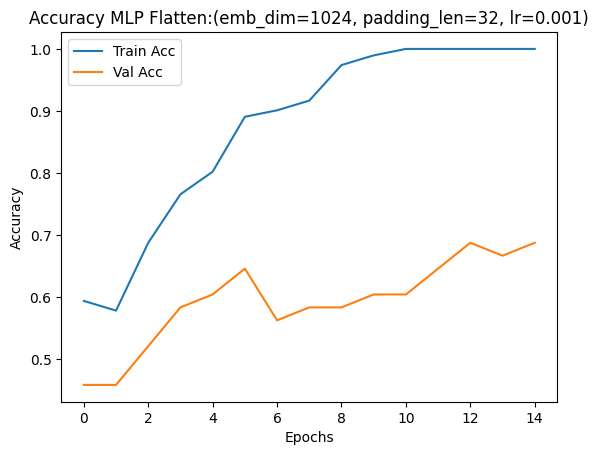

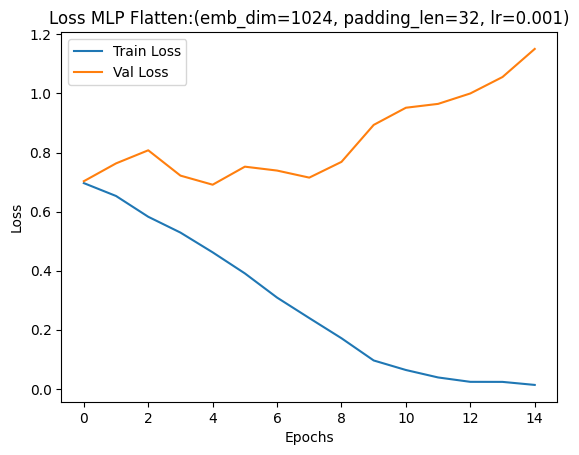

Test Accuracy: 0.6000, Loss: 0.7243


In [11]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss {choice}:(emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
=== 분류 성능 보고서 ===
              precision    recall  f1-score   support

          경미       0.58      0.70      0.64        30
          긴급       0.62      0.50      0.56        30

    accuracy                           0.60        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.60      0.60      0.60        60



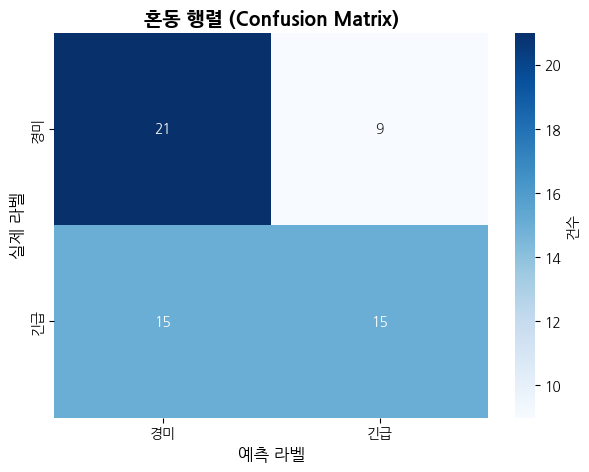

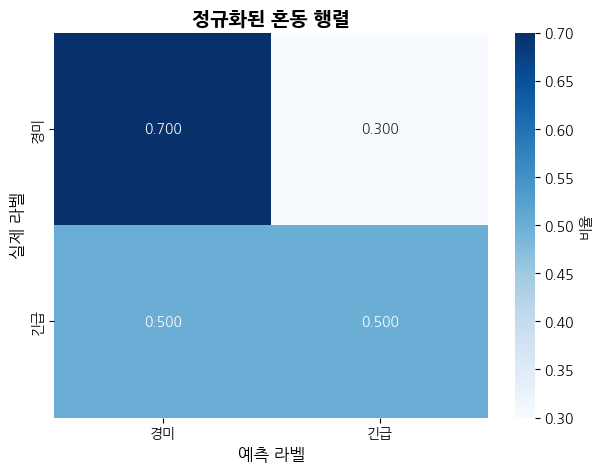

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import koreanize_matplotlib
import seaborn as sns

# Classification Report (한글)
# 예측 수행 (긴급=1, 경미=0 가정)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("=== 분류 성능 보고서 ===")
print(classification_report(y_test, y_pred,
                          target_names=['경미', '긴급']))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '건수'})
plt.title('혼동 행렬 (Confusion Matrix)', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()

# 정규화된 Confusion Matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '비율'})
plt.title('정규화된 혼동 행렬', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()